In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from train_lid_driven_cavity_eigenvectors import custom_loss

2024-04-25 16:14:36.109506: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 16:14:36.147386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ml_residuals_without = np.loadtxt("../experiments/2d/ml/residuals_without_pressure_solver.dat")
mgpcg_residuals_without = np.loadtxt("../experiments/2d/mgpcg/residuals_without_pressure_solver.dat")
cg_residuals_without = np.loadtxt("../experiments/2d/conjugate_gradient/residuals_without_pressure_solver.dat")

# Plot the residuals

# Set title, explain what plot ist
plt.figure(figsize=(16, 6))
plt.title("Residuals after each time step")
plt.plot(ml_residuals_without, label="AI-Assisted MGPCG")
plt.plot(mgpcg_residuals_without, label="MGPCG", alpha=0.7)
plt.plot(cg_residuals_without, label="CG", alpha=0.7)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.legend()
plt.show()

FileNotFoundError: ../experiments/2d/ml/residuals_without_pressure_solver.dat not found.

In [ ]:
ml_residuals_over_time = np.loadtxt("../experiments/2d/ml/residuals_over_time.dat")
mgpcg_residuals_over_time = np.loadtxt("../experiments/2d/mgpcg/residuals_over_time.dat")
cg_residuals_over_time = np.loadtxt("../experiments/2d/conjugate_gradient/residuals_over_time.dat")

# Plot the residuals
plt.title("Residuals over time")
plt.plot(ml_residuals_over_time, label="AI-Assisted MGPCG")
plt.plot(mgpcg_residuals_over_time, label="MGPCG", alpha=0.7)
plt.plot(cg_residuals_over_time, label="CG", alpha=0.7)

plt.yscale("log")
plt.xlabel("Seconds")
plt.ylabel("Residual")
plt.legend()
plt.show()

: 

In [3]:
grid_size_x = 34
grid_size_y = 34
dx = 1 / (grid_size_x)
dy = 1 / (grid_size_y)
dx2 = dx ** 2
dy2 = dy ** 2

# generate Matrix A which is the discretized Laplacian in 2D
A = np.zeros((grid_size_x * grid_size_y, grid_size_x * grid_size_y))
for i in range(grid_size_x):
    for j in range(grid_size_y):
        row = i * grid_size_y + j
        A[row, row] = -2 * (1 / dx2 + 1 / dy2)
        if i > 0:
            A[row, row - grid_size_y] = 1 / dx2
        if i < grid_size_x - 1:
            A[row, row + grid_size_y] = 1 / dx2
        if j > 0:
            A[row, row - 1] = 1 / dy2
        if j < grid_size_y - 1:
            A[row, row + 1] = 1 / dy2

In [4]:
A_inverse = np.linalg.inv(A)

e_data type: torch.float32


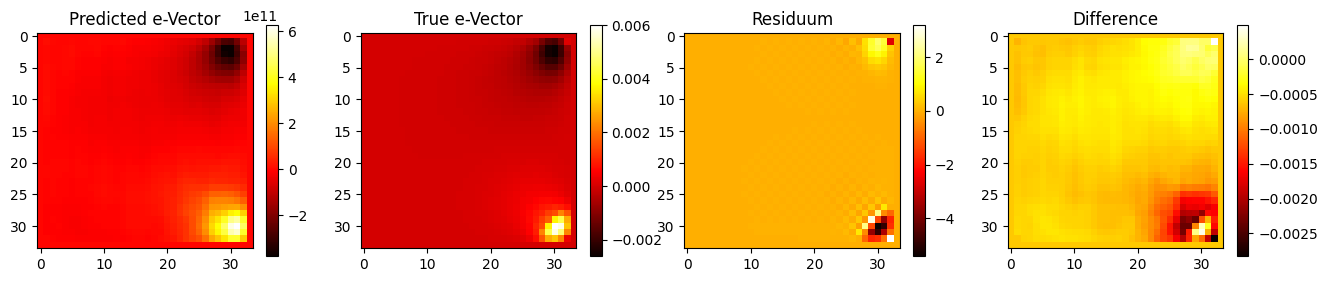

RHS Norm: 13.789712612528236
True Error Norm: 0.019714579393110637
Predicted Error Norm: 3066789625856.0
factor: 0.0014296584669356734


In [221]:
num_file = 1
residual_data = np.loadtxt(f"ML_data/res_{num_file}.dat")
true_error = np.loadtxt(f"ML_data/e_{num_file}.dat")
residual_data = torch.tensor(residual_data).to('cuda')

# Load the torchscript model
model = torch.jit.load("model_eigenvectors.pt")
model.eval()

# Calculate e_data with the model
with torch.no_grad():
    e_data = model(residual_data.float().unsqueeze(0).unsqueeze(0))
    # Plot e_data as heatmap
    e_data = e_data.to('cpu').squeeze(0).squeeze(0)
    np.savetxt("ff.dat", e_data.numpy())
    fig, axs = plt.subplots(1, 4, figsize=(16, 3))

    # Plot e_data from the model
    im1 = axs[0].imshow(e_data, cmap='hot', interpolation='nearest')
    axs[0].set_title('Predicted e-Vector')
    fig.colorbar(im1, ax=axs[0])

    # Calculate loss
    grid_size_x, grid_size_y = e_data.shape
    pred_error = e_data.unsqueeze(0).unsqueeze(0).to('cpu')
    true_error = torch.tensor(true_error).unsqueeze(0).unsqueeze(0).to('cpu')

# get data type of e_data
print(f"e_data type: {e_data.dtype}")

# Load e_data from file
e_data_true = np.loadtxt(f"ML_data/e_{num_file}.dat")
# Plot e_data from file as heatmap
im2 = axs[1].imshow(true_error.to('cpu').squeeze(0).squeeze(0), cmap='hot', interpolation='nearest')
axs[1].set_title('True e-Vector')
fig.colorbar(im2, ax=axs[1])

im3 = axs[2].imshow(residual_data.to('cpu').squeeze(0).squeeze(0), cmap='hot', interpolation='nearest')
axs[2].set_title('Residuum')
fig.colorbar(im3, ax=axs[2])

# difference between true and predicted e_data
# scale to same range
max_e_data_true = np.max(e_data_true)
min_e_data_true = np.min(e_data_true)
e_data = e_data.to('cpu').squeeze(0).squeeze(0).numpy()
# scale to same range as e_data_true with min_e_data_true and max_e_data_true
e_data = (e_data - np.min(e_data)) / (np.max(e_data) - np.min(e_data)) * (max_e_data_true - min_e_data_true) + min_e_data_true
im4 = axs[3].imshow(e_data_true - e_data, cmap='hot', interpolation='nearest')
axs[3].set_title('Difference')
fig.colorbar(im4, ax=axs[3])



plt.show()

print(f"RHS Norm: {torch.norm(residual_data).item()}")
print(f"True Error Norm: {torch.norm(true_error).item()}")
print(f"Predicted Error Norm: {torch.norm(pred_error).item()}")
print(f"factor: {torch.norm(true_error).item() / torch.norm(residual_data).item()}")

In [ ]:
# get size of the model
model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model size: {model_size}")

Model size: 291058


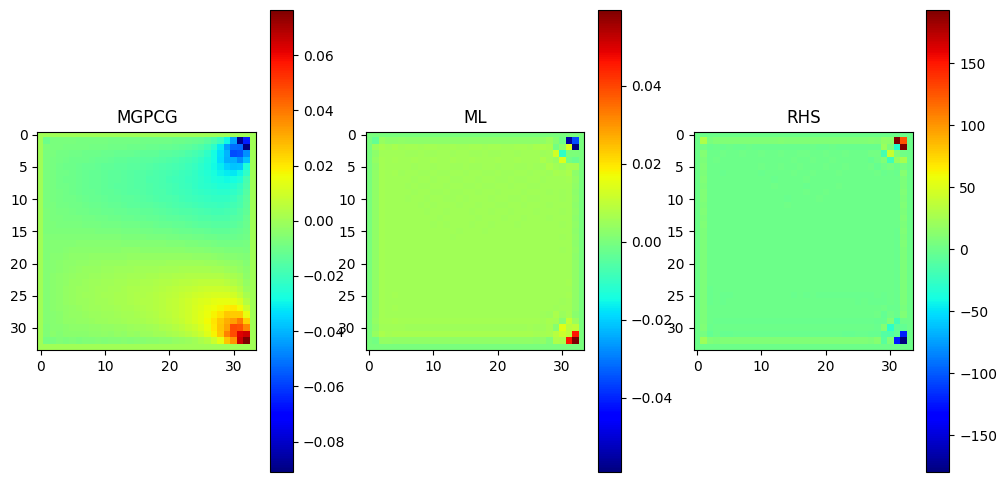

In [145]:
num_file = 3
mgpcg_data = np.loadtxt(f"../experiments/2d/ml/test/mgpcg_{num_file}.dat")
ml_data = np.loadtxt(f"../experiments/2d/ml/test/ml_{num_file}.dat")
rhs_Data = np.loadtxt(f"../experiments/2d/ml/test/RHS_{num_file}.dat")
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
im1 = axs[0].imshow(mgpcg_data, cmap='jet', interpolation='nearest')
axs[0].set_title('MGPCG')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(ml_data, cmap='jet', interpolation='nearest')
axs[1].set_title('ML')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(rhs_Data, cmap='jet', interpolation='nearest')
axs[2].set_title('RHS')
fig.colorbar(im3, ax=axs[2])

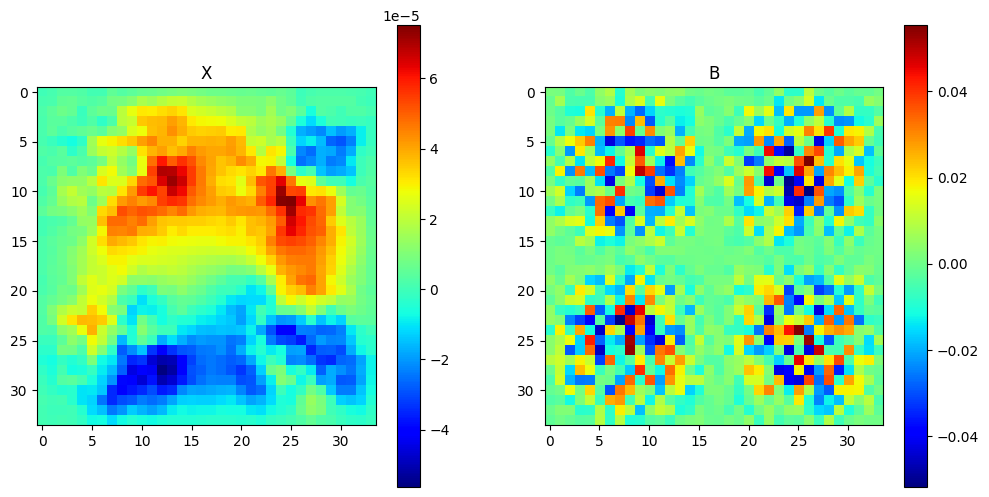

In [227]:
num_file = 1157
x_data = np.loadtxt(f"eigenvectors/x_{num_file}.dat")
b_data = np.loadtxt(f"eigenvectors/b_{num_file}.dat")
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im1 = axs[0].imshow(x_data, cmap='jet', interpolation='nearest')
axs[0].set_title('X')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(b_data, cmap='jet', interpolation='nearest')
axs[1].set_title('B')
fig.colorbar(im2, ax=axs[1])

In [ ]:
# Ghia et al. (1982) - Re = 100
reference_ux_RE_100 = {
    128: 1.00000,
    125: 0.84123,
    124: 0.78871,
    123: 0.73722,
    122: 0.68717,
    109: 0.23151,
    94: 0.00332,
    79: -0.13641,
    64: -0.20581,
    58: -0.21090,
    36: -0.15662,
    22: -0.10150,
    13: -0.06434,
    9: -0.04775,
    8: -0.04192,
    7: -0.03717,
    0: 0.00000
}

# Ghia et al. (1982) - Re = 100
reference_uy_RE_100 = {
    128: 0.00000,
    124: -0.05906,
    123: -0.07391,
    122: -0.08864,
    121: -0.10313,
    116: -0.16914,
    110: -0.22445,
    103: -0.24533,
    64: 0.05454,
    30: 0.17527,
    29: 0.17507,
    20: 0.16077,
    12: 0.12317,
    10: 0.10890,
    9: 0.10091,
    8: 0.09233,
    0: 0.00000
}

u = np.loadtxt("../experiments/2d/mgpcg/u.dat")
v = np.loadtxt("../experiments/2d/mgpcg/v.dat")

u = u[1:-1, 1:-1]
v = v[1:-1, 1:-1]

scale_factor = 4
u = np.kron(u, np.ones((scale_factor, scale_factor)))
v = np.kron(v, np.ones((scale_factor, scale_factor)))

# plot u
u = u[:, int(u.shape[1]/2)]
v = v[int(v.shape[0]/2), :]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 2 subplots side by side

# Plot u and its reference
axes[0].plot(u, label="MGPCG ML")
axes[0].scatter(reference_ux_RE_100.keys(), reference_ux_RE_100.values(), label="Ghia et al. (1982)")
axes[0].set_title("Velocity Component u")
axes[0].legend()

# Plot v and its reference
axes[1].plot(v, label="MGPCG ML")
# plot v_mid as scatter plot
axes[1].scatter(reference_uy_RE_100.keys(), reference_uy_RE_100.values(), label="Ghia et al. (1982)")
axes[1].set_title("Velocity Component v")
axes[1].legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

: 